# Noisy GP Experiments

In [1]:
import numpy as np
import numba
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn.utils import check_random_state, check_array, check_X_y
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics.pairwise import check_pairwise_arrays, euclidean_distances
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import _check_length_scale, WhiteKernel, RBF, ConstantKernel as C
from scipy import interpolate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
mpl.rcParams['savefig.pad_inches'] = 0

%matplotlib inline
%load_ext Cython
%load_ext autoreload
%autoreload 2

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## 1D Toy Example

In [2]:
figure_location = '/home/emmanuel/projects/2018_igarss/figures/noisy_gp/1d_example/'
figure_location = '/Users/eman/Documents/code_projects/gaussian_processes/pkg_sgpuppy/figures/'
figure_location = '/home/emmanuel/projects/gaussian_processes/pkg_sgpuppy/figures'

In [3]:
weights = {}
predictions = {}
variance = {}
scores = {}

### Sample Data

In [4]:
seed = 123
rng = np.random.RandomState(seed=seed)

# sample data parameters
n_train, n_test, n_trial = 60, 100, 100
sigma_y = 0.05
x_cov = 0.3
y_scale = .5
x_min, x_max = -10, 10

# real function
f = lambda x: np.sin(1.0 * np.pi / 1.6 * np.cos(5 + y_scale * x))
# f = lambda x: np.sinc(x)
# f = lambda x: np.sin(2. * x) + np.exp(0.2 * x)


# Training add x, y = f(x)
x = np.linspace(x_min, x_max, n_train + n_test + n_trial)


x, xs, = train_test_split(x, train_size=n_train, random_state=seed)

# add noise
y = f(x)
x_train = x + x_cov * rng.randn(n_train)
y_train = f(x) + sigma_y * rng.randn(n_train)

x_train, y_train = x_train[:, np.newaxis], y_train[:, np.newaxis]



# -----------------
# Testing Data
# -----------------
xs, xt = train_test_split(xs, train_size=n_test, random_state=seed)
xt = np.sort(xt)

ys = f(xs)

# Add noise
x_test = xs + x_cov * rng.randn(n_test)
y_test = ys

x_test, y_test = x_test[:, np.newaxis], y_test[:, np.newaxis]

# -------------------
# Plot Points
# -------------------
x_plot = np.linspace(x_min, x_max, n_test)[:, None]
y_plot = f(x_plot)

/home/emmanuel/.conda/envs/sci_py36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [5]:
print(x.shape, y.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, x_test.shape)

(60,) (60,)
(60, 1) (60, 1)
(100, 1) (100, 1)


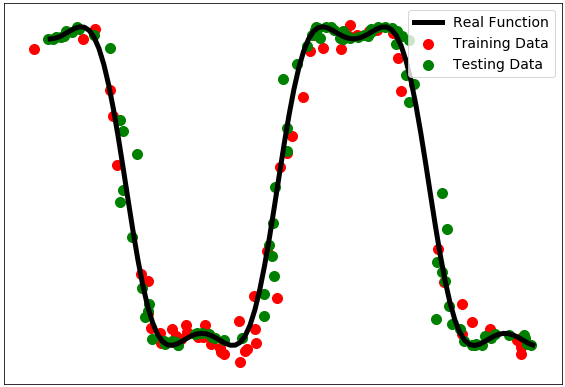

In [6]:
# plot toy data
fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, y_plot, linewidth=5, color='k', label='Real Function')
ax.scatter(x_train, y_train, color='r', s=100, label='Training Data')
ax.scatter(x_test, y_test, color='g', s=100, label='Testing Data')

# ax.set_title('Training and Testing Data', fontsize=20)
ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

save_name = 'training_data.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Naive GP Implementation (to Find Suitable Hyperparameters)

In [7]:
def fit_gp(x_train, y_train, kernel='ard', scale=None,
           length_scale_bounds = (0.001, 100),
           noise_level_bounds = (1e-4, 10),
           n_restarts=3):
    
    warnings.simplefilter('ignore')
    x_train, y_train = check_X_y(x_train, y_train)
    warnings.simplefilter('default')
    n_train, d_dims = x_train.shape
    
    if kernel in ['ard', 'ARD']:
        length_scale_init = np.ones(shape=(d_dims))
    elif kernel in ['rbf', 'RBF']:
        length_scale_init = 1.0
    else:
        raise ValueError('Unrecognized kernel function...')
    
    noise_level_init = 1.0

    gp_kernel = C() * RBF(length_scale=length_scale_init,
                    length_scale_bounds=length_scale_bounds) + \
                WhiteKernel(noise_level=noise_level_init,
                            noise_level_bounds=noise_level_bounds)
    
    gpr_model = GaussianProcessRegressor(kernel=gp_kernel, random_state=123,
                                         n_restarts_optimizer=n_restarts)
    
    # Fit the GP Model
    gpr_model.fit(x_train, y_train)
    
    # the parameters
    
    constant = gpr_model.kernel_.get_params()['k1__k1__constant_value']
    length_scale = gpr_model.kernel_.get_params()['k1__k2__length_scale']
    sigma = gpr_model.kernel_.get_params()['k2__noise_level']
    
    return length_scale, sigma, constant

In [8]:
length_scale, sigma_y, constant = fit_gp(x_train, y_train, n_restarts=0)
print('Length Scale: {:.3f}'.format(length_scale))
print('Sigma y: {:.3f}'.format(sigma_y))
print('Likelihood Variance: {:.3f}'.format(constant))

Length Scale: 1.854
Sigma y: 0.013
Likelihood Variance: 0.656


## Uncertainty Propagation Function

In [21]:
%%cython

import numpy as np
cimport numpy as np
from Covariance import tracedot
from numpy.linalg import inv, det
from libc.math cimport exp

DTYPE = np.float64
ctypedef np.float64_t DTYPE_t

#TODO: complete types

cdef class UncertaintyPropagationGA:
	"""
	Superclass for all UncertaintyPropagationGA Classes
	"""
	cdef object gp

	def __init__(self, object gp):
		"""

		:param gp: callable gaussian process that returns mean and variance for a given input vector x
		"""
		self.gp = gp

	cpdef double propagate_mean(self,np.ndarray[DTYPE_t,ndim=1] u,np.ndarray[DTYPE_t,ndim=2] Sigma_x):
		"""
		Propagates the mean using the gaussian approximation from Girard2004

		:param u: vector of means
		:param Sigma_x: covariance Matrix of the input
		:return: mean of the output
		"""
		return 0

	cpdef tuple propagate_GA(self,np.ndarray[DTYPE_t,ndim=1] u,np.ndarray[DTYPE_t,ndim=2] Sigma_x):
		"""
		Propagates the uncertainty.py using the gaussian approximation from Girard2004

		:param u: vector of means
		:param Sigma_x: covariance Matrix of the input
		:return: mean, variance of the output
		"""
		return 0, 0




cdef class UncertaintyPropagationExact(UncertaintyPropagationGA):
	
	cdef object Sigma_x
	cdef object Winv
	cdef object LambdaInv 
	cdef double normalize_C_corr2
	cdef object Deltainv
	cdef double normalize_C_corr 
	cdef object C_ux

	cdef _prepare_C_corr(self,int D):
		"""
		Prepares the constants for C_corr

		:param D: Number of dimensions of the input vectors
		"""
		#D = len(xi)
		cdef np.ndarray[DTYPE_t,ndim=2] I = np.eye(D)
		self.Deltainv = self.Winv - np.diag(
			np.array([self.Winv[i][i] / (1 + self.Winv[i][i] * self.Sigma_x[i][i]) for i in range(D)]))
		self.normalize_C_corr = 1 / np.sqrt(det(I + self.Winv * self.Sigma_x))

	cdef double _get_C_corr(self,np.ndarray[DTYPE_t,ndim=1] u,np.ndarray[DTYPE_t,ndim=1] xi):
		"""
		:param u: N-dimensional vector
		:param xi: N-dimensional vector
		:return: covariance correction factor
		"""
		diff = u - xi
		cdef double normalize_C_corr = self.normalize_C_corr
		cdef np.ndarray[DTYPE_t,ndim=2] Deltainv = self.Deltainv
		return  normalize_C_corr * np.exp(0.5 * (np.dot(diff.T, np.dot(Deltainv, diff))))


	cpdef double propagate_mean(self, np.ndarray[DTYPE_t,ndim=1] u,np.ndarray[DTYPE_t,ndim=2] Sigma_x):
		cdef np.ndarray[DTYPE_t,ndim=2] x = self.gp.x
		cdef int N
		cdef int d
		cdef list C_ux_t
		N = x.shape[0]
		d = x.shape[1]
		cdef np.ndarray[DTYPE_t,ndim=1] C_ux = self.C_ux
		if C_ux is None:
			C_ux_t = []
			for i in range(N):
				C_ux_t.append(self.gp._covariance(u,x[i]))
			C_ux = np.array(C_ux_t)

		cdef np.ndarray[DTYPE_t,ndim=1] beta = self.gp._get_beta()
		self.Winv = self.gp._get_W_inv()
		self.Sigma_x = Sigma_x

		assert(N == len(beta))
		self._prepare_C_corr(len(u))

		cdef double sum = 0.0
		for i in range(N):
			sum += beta[i] * C_ux[i] * self._get_C_corr(u, x[i])

		return sum

	cdef _prepare_C_corr2(self, D):
		"""
		Prepares the constants for C_corr2

		:param D: Number of dimensions of the input vectors
		"""

		#D = len(x)
		I = np.eye(D)
		W = np.diag(np.array([1 / self.Winv[i][i] for i in range(D)]))
		self.LambdaInv = 2 * self.Winv - inv(0.5 * W + self.Sigma_x)
		self.normalize_C_corr2 = 1 / np.sqrt(det(2 * self.Winv * self.Sigma_x + I))


	cdef _get_C_corr2(self, u, x):
		"""
		This function is alternatively calculated by weave inline C code

		:param u: N-dimensional vector
		:param xi: N-dimensional vector
		:return: covariance correction factor 2
		"""

		#D = len(x)
		#I = np.eye(D)
		#W = np.diag(np.array([1/self.Winv[i][i] for i in range(D)]))
		#LambdaInv = 2* self.Winv - inv(0.5*W+self.Sigma_x)
		diff = u - x

		return self.normalize_C_corr2 * np.exp(0.5 * (np.dot(diff.T, np.dot(self.LambdaInv, diff))))

	cpdef tuple propagate_GA(self,np.ndarray[DTYPE_t,ndim=1] u,np.ndarray[DTYPE_t,ndim=2] Sigma_x):
		cdef np.ndarray[DTYPE_t,ndim=1] beta = self.gp._get_beta()
		cdef np.ndarray[DTYPE_t,ndim=2] x = self.gp.x
		self.Winv = self.gp._get_W_inv()
		self.Sigma_x = Sigma_x
		cdef np.ndarray[DTYPE_t,ndim=2] Kinv = self.gp._inv_cov_matrix()
		cdef unsigned int N = x.shape[0]
		cdef unsigned int d = x.shape[1]
		assert(N == len(beta))
		cdef unsigned int i,j,i2,j2

		self._prepare_C_corr2(len(u))

		cdef list C_ux_ = []
		for i in range(N):
			C_ux_.append(self.gp._covariance(u,x[i]))
		cdef np.ndarray[DTYPE_t,ndim=1] C_ux = np.array(C_ux_)
		self.C_ux = C_ux
		mu = self.propagate_mean(u, Sigma_x)

		cdef double nc = self.normalize_C_corr2
		cdef np.ndarray[DTYPE_t,ndim=2] L = self.LambdaInv
		cdef double sum = 0.0
		cdef double dot = 0.0
		for i in range(N):
			for j in range(N):
				dot = 0.0
				for i2 in range(d):
					for j2 in range(d):	
						dot += (u[i2]-(x[i,i2]+x[j,i2])/2.0) * (u[j2]-(x[i,j2]+x[j,j2])/2.0) *L[i2,j2]
				sum += (Kinv[i,j] - beta[i] * beta[j]) * C_ux[i]*C_ux[j] * nc * exp(0.5 * dot)


		variance = self.gp._covariance(u, u) - sum - mu ** 2

		return mu + self.gp._get_mean_t(), variance




cdef class UncertaintyPropagationApprox(UncertaintyPropagationGA):

	cdef double v
	cdef object Winv
	cdef object u
	cdef object C_ux
	cdef object H_ux
	cdef object J_ux

	def __init__(self, gp):
		"""

		:param gp: callable gaussian process that returns mean and variance for a given input vector x
		"""
		UncertaintyPropagationGA.__init__(self, gp)
		self.v = self.gp._get_v()
		self.Winv = self.gp._get_W_inv()
		self.u = None

	cpdef double propagate_mean(self,np.ndarray[DTYPE_t,ndim=1] u, np.ndarray[DTYPE_t,ndim=2] Sigma_x):
		cdef np.ndarray[DTYPE_t,ndim=1] beta = self.gp._get_beta()
		cdef np.ndarray[DTYPE_t,ndim=2] x = self.gp.x
		cdef int n = len(x)
		cdef double mu = sum([beta[i]*self.C_ux[i] for i in range(n)])
		#print "Approx mean"
		#print mu
		#print 0.5 * sum([beta[i] * np.trace(np.dot(self.get_Hessian(u,x[i]),Sigma_x)) for i in range(n)])

		#Time complexity d**3 because of dot

		return mu + 0.5 * sum([beta[i] * np.trace(np.dot(self.H_ux[i],Sigma_x)) for i in range(n)])

	cdef double _get_sigma2(self,np.ndarray[DTYPE_t,ndim=1] u, np.ndarray[DTYPE_t,ndim=2] Kinv, np.ndarray[DTYPE_t,ndim=2]x,  np.ndarray[DTYPE_t,ndim=1] C_ux, np.ndarray[DTYPE_t,ndim=3]J_ux,  np.ndarray[DTYPE_t,ndim=3] H_ux):
		cdef int n = len(x)
		cdef unsigned int i,j
		cdef DTYPE_t sum_ = 0.0
		for i in range(n):
			for j in range(n):
				sum_ += Kinv[i,j]*C_ux[i]*C_ux[j]

		sigma2 = self.gp._covariance(u,u) - sum_#


		return sigma2

	cdef double _get_variance_rest(self,np.ndarray[DTYPE_t,ndim=1] u,np.ndarray[DTYPE_t,ndim=2] Sigma_x, np.ndarray[DTYPE_t,ndim=2] Kinv, np.ndarray[DTYPE_t,ndim=2] x,np.ndarray[DTYPE_t,ndim=1] beta, np.ndarray[DTYPE_t,ndim=1] C_ux, np.ndarray[DTYPE_t,ndim=3] J_ux, np.ndarray[DTYPE_t,ndim=3] H_ux):
		cdef int n = x.shape[0]
		cdef int d = x.shape[1]
		cdef unsigned int i,j,k
		cdef double trace_ = 0.0
		cdef np.ndarray[DTYPE_t,ndim=2] S = np.atleast_2d(np.diag(Sigma_x).copy()).T
		cdef double sum_ = 0.0
		for i in range(n):
			for j in range(n):
				trace_ = 0.0
				for k in range(d):
					trace_ += J_ux[i,k,0]*J_ux[j,k,0]*S[k,0]
				sum_ += (Kinv[i,j]-beta[i]*beta[j]) * trace_
		variance2 =- sum_ #sum([(Kinv[i][j]-beta[i]*beta[j]) * (J_ux[i]*J_ux[j]*S).sum() for i in range(n) for j in range(n)])

		cdef np.ndarray[DTYPE_t,ndim=1] trace = np.array([tracedot(H_ux[i],Sigma_x) for i in range(n)])
		
		sum_ = 0.0
		for i in range(n):
			for j in range(n):
				sum_ += Kinv[i,j]*(C_ux[i]*trace[j]+C_ux[j]*trace[i])
		variance3 = - 0.5* sum_ #sum([Kinv[i][j]*(C_ux[i]*trace[j]+C_ux[j]*trace[i]) for i in range(n) for j in range(n)])

		return variance2+variance3

	cdef tuple _get_sigma2_and_variance_rest(self,np.ndarray[DTYPE_t,ndim=1] u,np.ndarray[DTYPE_t,ndim=2] Sigma_x, np.ndarray[DTYPE_t,ndim=2] Kinv, np.ndarray[DTYPE_t,ndim=2] x, np.ndarray[DTYPE_t,ndim=1] beta):
		n = len(x)
		cdef double sigma2 = self._get_sigma2(u,Kinv,x,self.C_ux,self.J_ux,self.H_ux)
		cdef double variance_rest = self._get_variance_rest(u,Sigma_x,Kinv,x,beta,self.C_ux,self.J_ux,self.H_ux)

		return sigma2, variance_rest

	cpdef tuple propagate_GA(self,np.ndarray[DTYPE_t,ndim=1] u,np.ndarray[DTYPE_t,ndim=2] Sigma_x):
		beta = self.gp._get_beta()
		x = self.gp.x
		n = len(x)
		Kinv = self.gp._inv_cov_matrix()
		#Kinv = inv(self.gp.cov_matrix())

		#We store the values because we can reuse them
		if self.u is None or (self.u != u).any():

			self.u = u
			self.C_ux = []
			self.J_ux = []
			self.H_ux = []
			for i in range(n):
				self.C_ux.append(self.gp._covariance(u,x[i]))
				self.J_ux.append(self.gp._get_Jacobian(u,x[i]))
				self.H_ux.append(self.gp._get_Hessian(u,x[i]))
			self.C_ux = np.array(self.C_ux)
			self.J_ux = np.array(self.J_ux)
			self.H_ux = np.array(self.H_ux)
		print(np.ndim(u), np.ndim(Sigma_x))
		mean = self.propagate_mean(u,Sigma_x)
		sigma2, variance_rest = self._get_sigma2_and_variance_rest(u,Sigma_x,Kinv,x,beta)



		#TODO!!!: Only if C''(u,u) == 0
		variance = sigma2 + variance_rest




		return mean + self.gp._get_mean_t(), variance


	cpdef double _getFactor(self,u,Sigma_x,v):
		"""

		:param u: the mean
		:param Sigma_x: The weight_vector based cov matrix
		:param v: the limiting output variance
		:return: the lambda to multiply Sigma_x with
		"""
		#TODO!!!: consider predefined variances and divide into block matrices

		beta = self.gp._get_beta()
		x = self.gp.x
		n = len(x)

		Kinv = self.gp._inv_cov_matrix() #inv(self.gp.cov_matrix())
		#We store the values because we can reuse them
		if self.u is None or (self.u != u).any():

			self.u = u
			self.C_ux = []
			self.J_ux = []
			self.H_ux = []
			for i in range(n):
				self.C_ux.append(self.gp._covariance(u,x[i]))
				self.J_ux.append(self.gp._get_Jacobian(u,x[i]))
				self.H_ux.append(self.gp._get_Hessian(u,x[i]))
			self.C_ux = np.array(self.C_ux)
			self.J_ux = np.array(self.J_ux)
			self.H_ux = np.array(self.H_ux)

		sigma2, variance_rest = self._get_sigma2_and_variance_rest(u,Sigma_x,Kinv,x,beta)



		return (v-sigma2)/(variance_rest)



	cpdef double _get_variance_dv_h(self,np.ndarray[DTYPE_t,ndim=1] u,unsigned int h):
		cdef np.ndarray[DTYPE_t,ndim=1] beta = self.gp._get_beta()
		cdef np.ndarray[DTYPE_t,ndim=2] Kinv = self.gp._inv_cov_matrix()
		cdef np.ndarray[DTYPE_t,ndim=2] x = self.gp.x
		cdef unsigned int n = x.shape[0]
		cdef unsigned int d = x.shape[1]

		#We store the values because we can reuse them
		if self.u is None or (self.u != u).any():

			self.u = u
			self.C_ux = []
			self.J_ux = []
			self.H_ux = []
			for i in range(n):
				self.C_ux.append(self.gp._covariance(u,x[i]))
				self.J_ux.append(self.gp._get_Jacobian(u,x[i]))
				self.H_ux.append(self.gp._get_Hessian(u,x[i]))
			self.C_ux = np.array(self.C_ux)
			self.J_ux = np.array(self.J_ux)
			self.H_ux = np.array(self.H_ux)

		cdef np.ndarray[DTYPE_t,ndim=1] C_ux = self.C_ux
		cdef np.ndarray[DTYPE_t,ndim=3] H_ux = self.H_ux
		cdef np.ndarray[DTYPE_t,ndim=3] J_ux = self.J_ux

		cdef double sum_ = 0.0
		for i in range(n):
			for j in range(n):
				sum_ += (Kinv[i,j]-beta[i]*beta[j]) * J_ux[i,h,0]*J_ux[j,h,0]
		variance2 = - sum_ #sum([(Kinv[i,j]-beta[i]*beta[j]) * self.J_ux[i,h,0]*self.J_ux[j,h,0] for i in range(n) for j in range(n)])


		sum_ = 0.0
		for i in range(n):
			for j in range(n):
				sum_ += Kinv[i,j]*(C_ux[i]*H_ux[j,h,h] +C_ux[j]*H_ux[i,h,h])
		variance3 = - 0.5* sum_ #sum([Kinv[i,j]*(C_ux[i]*H_ux[j,h,h] +C_ux[j]*H_ux[i,h,h]) for i in range(n) for j in range(n)])


		return variance2+variance3



## Gaussian Covariance Function (ARD/RBF Kernel)

\begin{equation}
    K(x, y) = \nu \cdot \text{exp} \left[ -\frac{1}{2} (x - y)^{\top} \cdot W^{-1} \cdot (x - y) \right]
\end{equation}

* $W^{-1}= \text{diag}\left[ w_1, w_2, \ldots, w_{D} \right]$
* $w_d = \frac{1}{\lambda_d^2}$
* $\nu$ is the signal variance parameter

### GP/KRR Manually

In [11]:
from GaussianProcess import GaussianProcess
from Covariance import GaussianCovariance

In [12]:
w = np.array([length_scale])
v = constant
vt = sigma_y
Sigma = np.array([0.8])
if np.ndim(Sigma) == 1:
    Sigma = Sigma[:, np.newaxis]

# Preparing the parameter vector
theta = np.zeros(2+len(w))
theta[0] = np.log(v)  # We actually use the log of the parameters as it is easier to optimize (no > 0 constraint etc.)
theta[1] = np.log(vt)
theta[2:2+len(w)] = np.log(w)

# Simulating simulation data by drawing data from a random Gaussian process
t = GaussianProcess.get_realisation(x_train, GaussianCovariance(),theta)

# The regression step is pretty easy:
# Input data x (list of input vectors)
# Corresponding simulation output t (just a list of floats of the same length as x)
# Covariance function of your choice (only GaussianCovariance can be used for uncertainty propagation at the moment)
gp_est = GaussianProcess(x_train, y_train,GaussianCovariance());

[-0.44196361 -1.82825797 -4.62977644]
l_bfgs_b 	 0.08210444450378418 	 [[-14.67484715]] 	 [-0.37193111 -4.30782621 -1.25336646]
[-0.37193111 -4.30782621 -1.25336646]


In [13]:
%%time
# Initialize the GP and Fit the model
gp_model = GaussianProcess(x_train, y_train,GaussianCovariance());

# Predict
predictions['simple'], var = gp_model.estimate_many(x_test);

scores['simple'] = mean_absolute_error(predictions['simple'], y_test)
print('\nMAE Score: {:.5f}\n'.format(scores['simple']))
print(var.min(), var.max())

[-0.44196361 -1.82825797 -4.62977644]
l_bfgs_b 	 0.09357762336730957 	 [[-14.67484715]] 	 [-0.37193111 -4.30782621 -1.25336646]
[-0.37193111 -4.30782621 -1.25336646]

MAE Score: 0.11215

0.015185502005075069 0.035744759522648994
CPU times: user 386 ms, sys: 2.84 s, total: 3.23 s
Wall time: 104 ms


#### Plot Simple GP Results

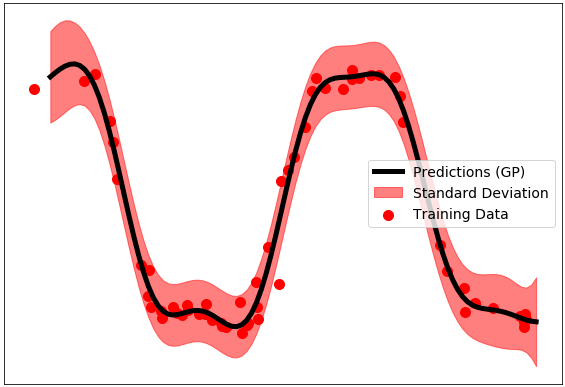

In [14]:
# Get Figure for x_plot
predictions['simple'], variance['simple'] = gp_model.estimate_many(x_plot)


# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['simple'], linewidth=5, color='k', label='Predictions (GP)')
ax.fill_between(x_plot.squeeze(), 
                predictions['simple'].squeeze() - 2*np.sqrt(variance['simple']).squeeze(),
                predictions['simple'].squeeze() + 2*np.sqrt(variance['simple']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_simple.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Uncertainty Propagation (Approximate)

In [15]:
# from UncertaintyPropagation import UncertaintyPropagationApprox

In [19]:
%%time 

# Initialize GP
gp_approx = UncertaintyPropagationApprox(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['approx'] = np.zeros(n_samples)
var = np.zeros(n_samples)

for i in range(n_samples):
    print(x_test[i].shape)
    print(x_test[i].ndim, Sigma.ndim)
#     predictions['approx'][i], var[i] = gp_approx.propagate_GA(x_test[i],Sigma)
    _, _ = gp_approx.propagate_GA(x_test[i],Sigma)

    break
scores['approx'] = mean_absolute_error(predictions['approx'], y_test)
print('\nMAE Score: {:.5f}\n'.format(scores['approx']))
print(var.min(), var.max())

(1,)
1 2


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

Exception ignored in: '_cython_magic_65b83ebca6d5c98a779c945b6853e237.UncertaintyPropagationApprox.propagate_mean'
ValueError: Buffer has wrong number of dimensions (expected 1, got 2)


ValueError: Buffer has wrong number of dimensions (expected 1, got 2)

##### Plot Derivative Term Results

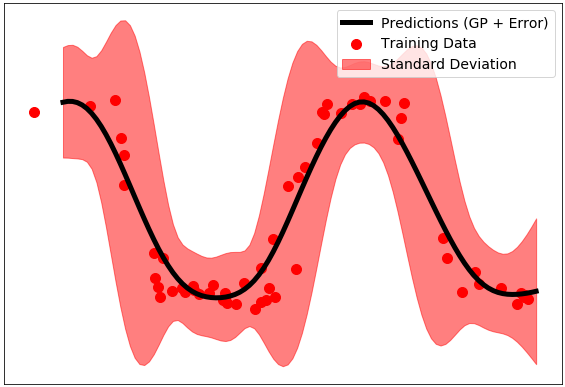

In [163]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['approx'] = np.zeros(n_samples)
variance['approx'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['approx'][i], variance['approx'][i] = gp_approx.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['approx'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['approx'].squeeze() - 2*np.sqrt(variance['approx']).squeeze(),
                predictions['approx'].squeeze() + 2*np.sqrt(variance['approx']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_approx.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Exact Uncertainty

In [164]:
from UncertaintyPropagation import UncertaintyPropagationExact

In [165]:
%%time
# Initialize GP
gp_exact = UncertaintyPropagationExact(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['exact'] = np.zeros(n_samples)
var = np.zeros(n_samples)

for i in range(n_samples):

    predictions['exact'][i], var[i] = gp_exact.propagate_GA(x_test[i],Sigma)
    
scores['exact'] = mean_absolute_error(predictions['exact'], y_test)
print('\nMAE Score: {:.5f}\n'.format(scores['exact']))
print(var.min(), var.max())


MAE Score: 0.20656

0.04141351054176534 0.3892824696322148
CPU times: user 4.66 s, sys: 71.2 ms, total: 4.73 s
Wall time: 4.65 s


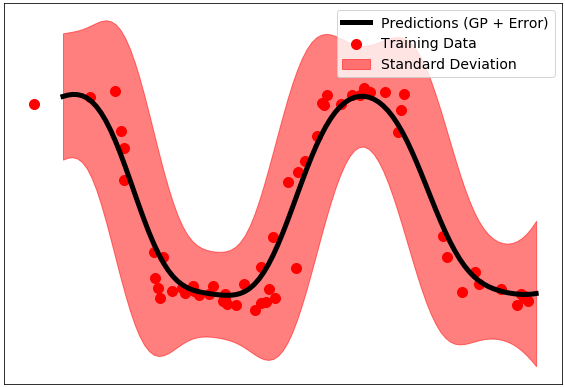

In [166]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['exact'] = np.zeros(n_samples)
variance['exact'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['exact'][i], variance['exact'][i] = gp_exact.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['exact'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['exact'].squeeze() - 2*np.sqrt(variance['exact']).squeeze(),
                predictions['exact'].squeeze() + 2*np.sqrt(variance['exact']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_exact.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Exact Numerical Uncertainty MCMC

In [145]:
from UncertaintyPropagation import UncertaintyPropagationMC

In [147]:
%%time
# Initialize GP
gp_stat = UncertaintyPropagationMC(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['stat'] = np.zeros(n_samples)
var = np.zeros(n_samples)

for i in range(n_samples):

    predictions['stat'][i], var[i] = gp_stat.propagate_GA(x_test[i],Sigma)
    
scores['stat'] = mean_absolute_error(predictions['stat'], y_test)
print('\nMAE Score: {:.5f}\n'.format(scores['stat']))
print(var.min(), var.max())


MAE Score: 0.15482

0.03645299933786017 0.3896251934569724
CPU times: user 32.7 s, sys: 1.78 ms, total: 32.7 s
Wall time: 32.7 s


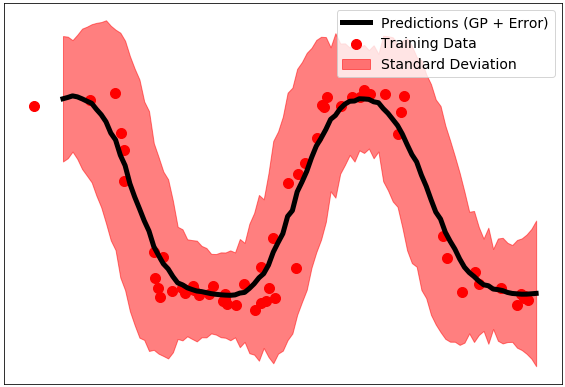

In [167]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['stat'] = np.zeros(n_samples)
variance['stat'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['stat'][i], variance['stat'][i] = gp_stat.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['stat'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['stat'].squeeze() - 2*np.sqrt(variance['stat']).squeeze(),
                predictions['stat'].squeeze() + 2*np.sqrt(variance['stat']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_stat.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Numerical

In [168]:
from UncertaintyPropagation import UncertaintyPropagationNumericalHG

In [169]:
%%time
# Initialize GP
gp_numerical = UncertaintyPropagationNumericalHG(gp_model)

# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_test)
predictions['numerical'] = np.zeros(n_samples)
var = np.zeros(n_samples)

for i in range(n_samples):

    predictions['numerical'][i], var[i] = gp_numerical.propagate_GA(x_test[i],Sigma)
    
scores['numerical'] = mean_absolute_error(predictions['numerical'], y_test)
print('\nMAE Score: {:.5f}\n'.format(scores['numerical']))
print(var.min(), var.max())


MAE Score: 0.20668

0.03997094081396435 0.40155955288059003
CPU times: user 254 ms, sys: 1.82 ms, total: 256 ms
Wall time: 254 ms


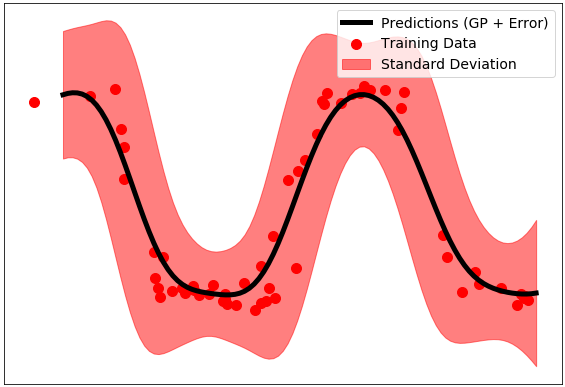

In [170]:
# Get Figure for x_plot
# print(x_new.shape, mean.shape, Sigma.shape)
n_samples = len(x_plot)
predictions['numerical'] = np.zeros(n_samples)
variance['numerical'] = np.zeros(n_samples)

for i in range(n_samples):

    predictions['numerical'][i], variance['numerical'][i] = gp_numerical.propagate_GA(x_plot[i],Sigma)
    

# Plot Figure

fig, ax = plt.subplots(figsize=(10, 7))

ax.plot(x_plot, predictions['numerical'], linewidth=5, color='k', label='Predictions (GP + Error)')
ax.scatter(x_train, y_train, s=100, color='r', label='Training Data')
ax.fill_between(x_plot.squeeze(), 
                predictions['numerical'].squeeze() - 2*np.sqrt(variance['numerical']).squeeze(),
                predictions['numerical'].squeeze() + 2*np.sqrt(variance['numerical']).squeeze(), 
                color = 'red',
                alpha=0.5, label='Standard Deviation')

ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
plt.show()

save_name = 'gp_numerical.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)

## Empirical Variance Comparison


### Calculate the Empirical Variance (Get Scores)

In [ ]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error
rng = np.random.RandomState(None)
n_trials = 20

mae_score = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}

mse_score = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}

abs_error = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}
squared_error = {
    'simple': list(),
    'approx': list(),
    'exact': list(),
    'stat': list(),
    'numerical': list()
}

# testing set (noise-less)
ys = f(xt)
y_test = ys.squeeze()
y_test = np.atleast_2d(y_test).T

# fig, ax = plt.subplots()


for itrial in range(n_trials):
    
    # Generate x samples with random error
    x_test = xt + 0.3 * rng.randn(n_trial)
    x_test = x_test[:, np.newaxis]
    n_samples = len(x_test)
#     ax.scatter(x_test, y_test)

    
    # -------------------
    # Model I - Simple GP
    # -------------------
    mean, _ = gp_model.estimate_many(x_test)
    
    abs_error['simple'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['simple'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['simple'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['simple'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))
    
    # -------------------
    # Model II - Approx
    # -------------------
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        
        mean[i], _ = gp_approx.propagate_GA(x_test[i],Sigma)
    
    abs_error['approx'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['approx'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['approx'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['approx'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))

    # -------------------
    # Model III - Exact
    # -------------------
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        
        mean[i], _ = gp_exact.propagate_GA(x_test[i],Sigma)
    
    abs_error['exact'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['exact'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['exact'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['exact'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))   

    # -------------------
    # Model IV - Numerical
    # -------------------
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        
        mean[i], _ = gp_stat.propagate_GA(x_test[i],Sigma)
    
    abs_error['stat'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['stat'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['stat'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['stat'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))

    # -------------------
    # Model IV - Numerical
    # -------------------
    mean = np.zeros(n_samples)
    for i in range(n_samples):
        
        mean[i], _ = gp_numerical.propagate_GA(x_test[i],Sigma)
    
    abs_error['numerical'].append(np.abs(mean.squeeze() - y_test.squeeze()))
    squared_error['numerical'].append((mean.squeeze() - y_test.squeeze())**2)  
    mae_score['numerical'].append(mean_absolute_error(mean.squeeze(), y_test.squeeze()))
    mse_score['numerical'].append(mean_squared_error(mean.squeeze(), y_test.squeeze()))


In [ ]:
abs_error['simple'] = np.mean(np.array(abs_error['simple']).squeeze(), axis=0)
squared_error['simple'] = np.mean(np.array(squared_error['simple']).squeeze(), axis=0)
mae_score['simple'] = np.mean(np.array(mae_score['simple']))
mse_score['simple'] = np.mean(np.array(mse_score['simple']))

abs_error['approx'] = np.mean(np.array(abs_error['approx']).squeeze(), axis=0)
squared_error['approx'] = np.mean(np.array(squared_error['approx']).squeeze(), axis=0)
mae_score['approx'] = np.mean(np.array(mae_score['approx']))
mse_score['approx'] = np.mean(np.array(mse_score['approx']))

abs_error['exact'] = np.mean(np.array(abs_error['exact']).squeeze(), axis=0)
squared_error['exact'] = np.mean(np.array(squared_error['exact']).squeeze(), axis=0)
mae_score['exact'] = np.mean(np.array(mae_score['exact']))
mse_score['exact'] = np.mean(np.array(mse_score['exact']))

abs_error['stat'] = np.mean(np.array(abs_error['stat']).squeeze(), axis=0)
squared_error['stat'] = np.mean(np.array(squared_error['stat']).squeeze(), axis=0)
mae_score['stat'] = np.mean(np.array(mae_score['stat']))
mse_score['stat'] = np.mean(np.array(mse_score['stat']))
                       
abs_error['numerical'] = np.mean(np.array(abs_error['numerical']).squeeze(), axis=0)
squared_error['numerical'] = np.mean(np.array(squared_error['numerical']).squeeze(), axis=0)
mae_score['numerical'] = np.mean(np.array(mae_score['numerical']))
mse_score['numerical'] = np.mean(np.array(mse_score['numerical']))

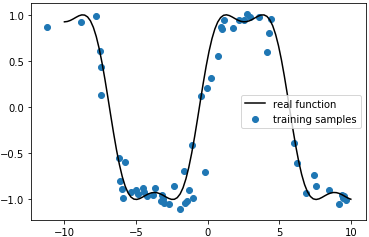

In [179]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train, label='training samples')
ax.plot(x_plot, f(x_plot), color='black', label='real function')
ax.legend()
plt.show()
# ax.scatter(xs, abs_error['simple'], color='green', label='Empirical Absolute Error (Points)')

### No Uncertainty

MSE: 0.04348
MAE: 0.13487


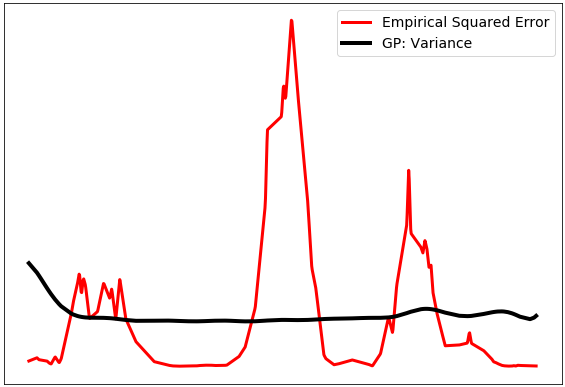

In [180]:
xnew = np.linspace(xt.min(), xt.max(), 1000)


# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['simple'], kind='slinear')(xnew)

print('MSE: {:.5f}'.format(mse_score['simple']))
print('MAE: {:.5f}'.format(mae_score['simple']))

pred, var = gp_model.estimate_many(xt[:, np.newaxis])

# pred, var = gp_simple.predict(xt[:, np.newaxis], return_variance=True)

fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Variance')

# ax.set_title('Squared Error, Variance')
ax.grid(True)
ax.legend(fontsize=14)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show()

save_name = 'exp_empirical_simple_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)




## Approximate Uncertainty

MSE: 0.06316
MAE: 0.18134


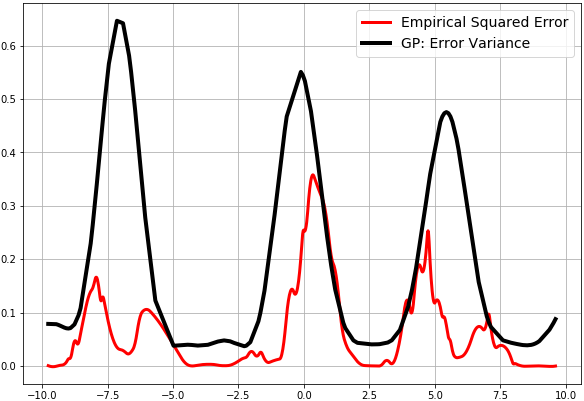

In [185]:
xnew = np.linspace(xt.min(), xt.max(), 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['approx'], kind='quadratic')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['approx'], kind='quadratic')(xnew)

n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]

for i in range(n_samples):
    pred[i], var[i] = gp_approx.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)


print('MSE: {:.5f}'.format(mse_score['approx']))
print('MAE: {:.5f}'.format(mae_score['approx']))


fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Error Variance')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_approx_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


### Exact Uncertainty

MSE: 0.05593
MAE: 0.16733


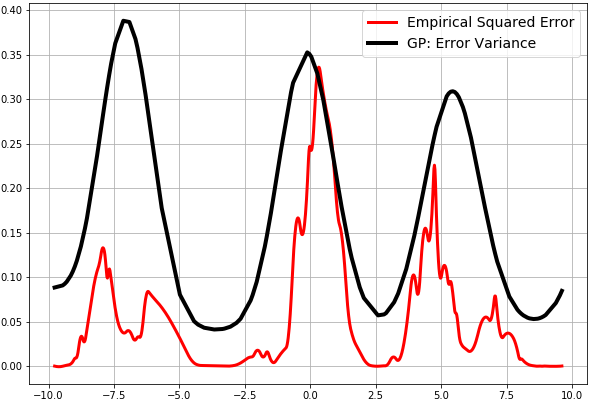

In [186]:
xnew = np.linspace(xt.min(), xt.max(), 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['exact'], kind='quadratic')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['exact'], kind='quadratic')(xnew)

n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]

for i in range(n_samples):
    pred[i], var[i] = gp_exact.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)


print('MSE: {:.5f}'.format(mse_score['exact']))
print('MAE: {:.5f}'.format(mae_score['exact']))


fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Error Variance')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_exact_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


## Numcerical Uncertainty (MC)

MSE: 0.05619
MAE: 0.16787


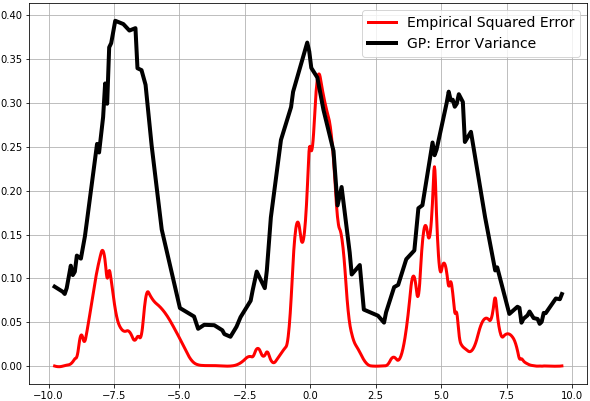

In [187]:
xnew = np.linspace(xt.min(), xt.max(), 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['stat'], kind='quadratic')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['stat'], kind='quadratic')(xnew)

n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]

for i in range(n_samples):
    pred[i], var[i] = gp_stat.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)


print('MSE: {:.5f}'.format(mse_score['stat']))
print('MAE: {:.5f}'.format(mae_score['stat']))


fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Error Variance')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_stat_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


### Numerical Uncertainty

MSE: 0.05601
MAE: 0.16742


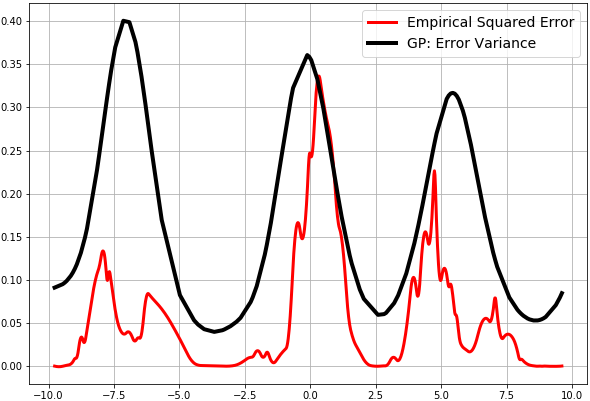

In [188]:
xnew = np.linspace(xt.min(), xt.max(), 1000)

abs_error_line = interpolate.interp1d(xt, abs_error['numerical'], kind='quadratic')(xnew)

# Interpolation function for squared error
squared_error_line = interpolate.interp1d(xt, squared_error['numerical'], kind='quadratic')(xnew)

n_samples = len(xt)
pred = np.zeros(n_samples)
var = np.zeros(n_samples)
xt_ = xt[:, np.newaxis]

for i in range(n_samples):
    pred[i], var[i] = gp_numerical.propagate_GA(xt_[i], Sigma)
# pred, var = gp_derivative_full.predict(xt[:, np.newaxis], return_variance=True)


print('MSE: {:.5f}'.format(mse_score['numerical']))
print('MAE: {:.5f}'.format(mae_score['numerical']))


fig, ax = plt.subplots(nrows=1, figsize=(10, 7))

ax.plot(xnew, squared_error_line, linewidth=3, color='r', label='Empirical Squared Error')
ax.plot(xt, var, linewidth=4, color='k', label='GP: Error Variance')

# ax.set_title('Squared Error, Variance')
ax.legend(fontsize=14)
# ax.get_xaxis().set_visible(False)
# ax.get_yaxis().set_visible(False)
ax.grid(True)
plt.show()

save_name = 'exp_empirical_numerical_var.png'
fig.savefig(figure_location + save_name, bbox_inhces='tight',
            dpi=100, transparent=True, frameon=None)


### Q Matrix Optimization

In [276]:
xtrain = np.array([1, 5, 3])[:, np.newaxis]
xtest = np.array([1])[:, np.newaxis]
print(xtrain.shape, xtest.shape)
n_samples = xtrain.shape[0]
d_dimensions = xtrain.shape[1]

(3, 1) (1, 1)


In [216]:
xrow = xtrain[:, np.newaxis, :]
xrow = np.tile(xrow, [1, n_samples, d_dimensions])
print(xrow)
print(xrow.shape)

[[[1]
  [1]
  [1]]

 [[5]
  [5]
  [5]]

 [[3]
  [3]
  [3]]]
(3, 3, 1)


In [217]:
def zterm_matrix(xtrain):
    n_samples, d_dimensions = xtrain.shape
    
    xrow = xtrain[:, np.newaxis, :]
    xrow = np.tile(xrow, [1, n_samples, d_dimensions])
    zterm = 0.5 * (xrow + np.transpose(xrow, axes=(1,0, 2)))
    return zterm

In [94]:
xcol = xrow.copy() #xtrain[:, np.newaxis, :]
xcol = np.transpose(xcol, axes=(1,0, 2))
print(xcol)
print(xcol.shape)



[[[1]
  [5]
  [3]]

 [[1]
  [5]
  [3]]

 [[1]
  [5]
  [3]]]
(3, 3, 1)


In [95]:
zterm = 0.5 * (xrow + xcol)
zterm = zterm_matrix(xtrain)
print(zterm == zterm2)
print(zterm.shape)

NameError: name 'zterm2' is not defined

In [91]:
zterm = zterm_matrix(xtrain)
zterm = zterm - xtest
print(zterm.shape, zterm.T.shape)

(3, 3, 1) (1, 3, 3)


In [95]:
diag_term = np.array([1.0])
print(zterm.shape, diag_term.shape)
exp_term = zterm.dot(diag_term).dot(zterm.T)
print(exp_term.shape)

(3, 3, 1) (1,)
(3, 1, 3)
